In [1]:
import corner
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc

In [3]:
# Load data products from executable --- FIXME: this is horrendous
post_samples = np.load('post_samples.npy')
counts_true = np.load('counts_true.npy')

with open('glitch_kdes.pkl', 'rb') as f:
        glitch_kdes = pickle.load(f)
        
with open('collection.pkl', 'rb') as f:
        collection = pickle.load(f)

/Users/eachase/Documents/research/rates/gw_rates/gwrates/rates_tools.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/eachase/miniconda3/envs/rates/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/eachase/miniconda3/envs/rates/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/eachase/miniconda3/envs/rates/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/eachase/miniconda3/envs/rates/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/eachase/miniconda3/envs/rates/lib/

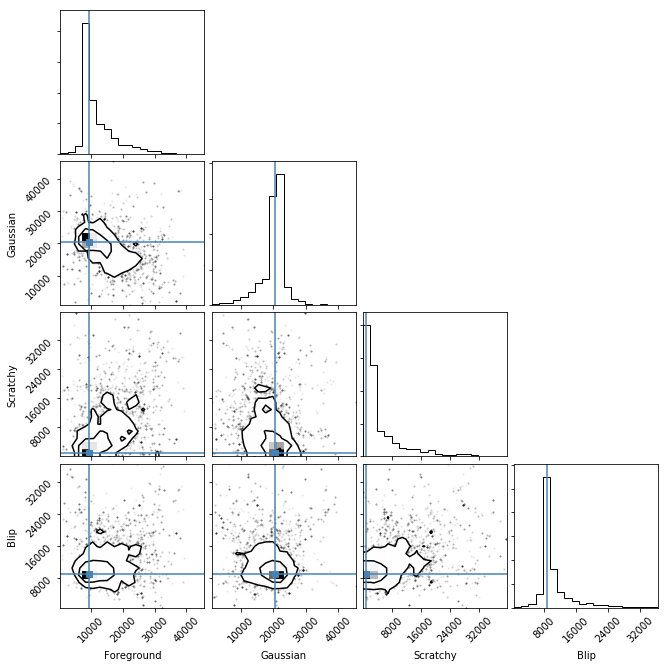

In [4]:
# Plot corner plot
source_classes = ['Foreground', 'Gaussian', 'Scratchy', 'Blip']
fig = corner.corner(post_samples, 
                    labels=source_classes, 
                    truths=counts_true)  


# Compute P(astro)
Calculate the probability that a given SNR value comes from the foreground distribution. Perform this calculation for each set of posterior samples.

In [41]:
def compute_pastro(snr, post_samples, source_classes, glitch_kdes, 
                   xmin=3.5, num_iters=500):
    """
    Calculate the probability that a given SNR sample
    comes from an astrophysical distribution.
    
    Parameters:
    -----------
    snr: float
        value of signal to noise ratio of interest
        
    post_samples: array of floats
        array of posterior samples of dimension 
        (num_samples, num_source_classes) where 
        num_samples is the number of posterior 
        samples and num_source_classes is the number
        of classes considered (i.e. foreground, gaussian, etc.)
        
    source_classes: array of strings
        Each entry corresponds to the name of a type of 
        source class: Foreground, Background, Blip, Scratchy, etc.
        
    glitch_kdes: dictionary
        Evaluated KDE for each GravitySpy glitch class. 
        Keys are strings of GravitySpy class names.
        
    xmin: float
        Minimum threshold SNR    
    
    num_iters: int
        number of samples drawn for Monte Carlo integration
        
    Returns:
    --------
    float or array
        P(astro) for each SNR value provided. 
        This only returns one P(astro) if only one SNR is provided.
    
    """

    likelihood_ratio = 0

    # Loop over N iterations
    for i in np.arange(num_iters):

        # Draw a sample from the posterior (some set of counts)
        counts_post = post_samples[
            np.random.randint(0, post_samples.shape[0])]

        # Compute the "likelihood ratio" for the drawn posterior sample
        foreground_like = counts_post[0] * 3 * xmin**3 * snr**(-4)

        gaussian_like = counts_post[1] * (np.sqrt(np.pi/2) * erfc(
                    xmin / np.sqrt(2)))**(-1) * np.exp(-snr**2 / 2)

        glitch_like = 0
        # All GSpy glitches have an SNR greater than 7.5
        if snr >= 7.5:
            for idx, iglitchtype in enumerate(source_classes[2:]):
                glitch_like += counts_post[idx+2] * np.exp(
                    glitch_kdes[iglitchtype].score_samples(snr))[0]

        # Add to other samples
        likelihood_ratio += foreground_like / (
            foreground_like + gaussian_like + glitch_like)


    # Report sum divided by N
    return likelihood_ratio / num_iters


In [45]:
compute_pastro(6, post_samples, source_classes, glitch_kdes)


0.9994845289141729

In [34]:
print(post_samples.shape)

# Pick random int between 0 and len(post_samples)
rand_choice = np.random.randint(0, post_samples.shape[0], size=10)
print(post_samples[rand_choice,:][:,0])

(10000, 4)
[ 8640.51862509  8531.4479602  13048.34626413  8085.21809664
 21129.38163066  8825.11409033  9187.41979971  8813.00022311
  9208.33852617  8948.02788225]


In [40]:
np.asarray(collection.samples['Scratchy'])

array([ 7.94239998,  8.24466991,  9.16069031, ...,  7.63689995,
       10.56124973,  7.99389982])